In [35]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
v=3
quantiles = [
    0,1, 
    0.005, 0.995, 
    0.01, 0.99, 
    0.05, 0.95,
    0.5
]

In [22]:
ssp_gdp = (
    xr.open_zarr(
        "/shares/gcp/integration/float32/dscim_input_data/econvars/zarrs/integration-econ-bc39.zarr",
        consolidated=True,
    )
    .sum("region")
    .gdp
)

# get RFF data
rff_gdp = (
    xr.open_dataset(
        f"/shares/gcp/integration/rff/socioeconomics/rff_global_socioeconomics.nc4"
    )
    .sel(region="world", drop=True)
    .gdp
)

# get RFF emulator weights
weights = xr.open_zarr(
    f"/shares/gcp/integration/rff/damage_function_weights/damage_function_weights{v}.zarr",
    consolidated=True,
).value

In [23]:
emu_gdp  = (ssp_gdp * weights).sum(["ssp", "model"])

In [24]:
scaling = (rff_gdp / emu_gdp).to_dataframe('scaling_factor').reset_index()
scaling_quant = (rff_gdp / emu_gdp).chunk({'rff_sp' : -1}).quantile(quantiles, 'rff_sp').to_dataframe('scaling_factor').reset_index()

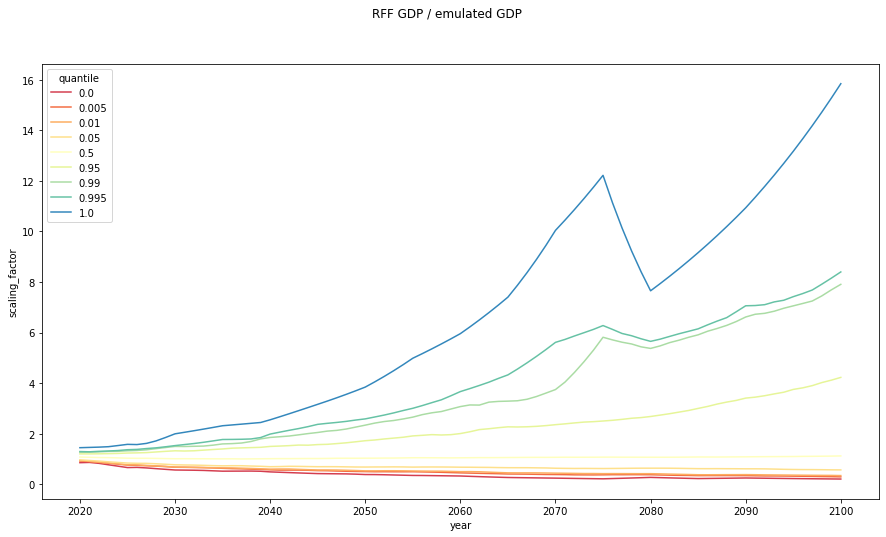

In [40]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=scaling_quant,
             x='year',
             y='scaling_factor',
             hue='quantile',
             palette=sns.color_palette('Spectral', len(quantiles)),
             legend='full', 
             ax=ax
            )

fig.suptitle("RFF GDP / emulated GDP")

plt.savefig(f"/mnt/CIL_integration/rff_diagnostics/v{v}/scaling_factor_timeseries.png", bbox_inches='tight', dpi=300)